# data save & load

In [ ]:
import json
import pandas as pd
import os
import shutil

DATA_DIR = "/content/drive/MyDrive/"
DATA_FILE = os.path.join(DATA_DIR, "data.json")
DUMP_FILE = os.path.join(DATA_DIR, "dump.pkl")

store_columns = (
    "id",  # 음식점 고유번호
    "store_name",  # 음식점 이름
    "branch",  # 음식점 지점 여부
    "area",  # 음식점 위치
    "tel",  # 음식점 번호
    "address",  # 음식점 주소
    "latitude",  # 음식점 위도
    "longitude",  # 음식점 경도
    "category",  # 음식점 카테고리
)

review_columns = (
    "id",  # 리뷰 고유번호
    "store",  # 음식점 고유번호
    "user",  # 유저 고유번호
    "score",  # 평점
    "content",  # 리뷰 내용
    "reg_time",  # 리뷰 등록 시간
)


def import_data(data_path=DATA_FILE):
    """
    Req. 1-1-1 음식점 데이터 파일을 읽어서 Pandas DataFrame 형태로 저장합니다
    """

    try:
        with open(data_path, encoding="utf-8") as f:
            data = json.loads(f.read())
    except FileNotFoundError as e:
        print(f"`{data_path}` 가 존재하지 않습니다.")
        exit(1)

    stores = []  # 음식점 테이블
    reviews = []  # 리뷰 테이블

    for d in data:

        categories = [c["category"] for c in d["category_list"]]
        stores.append(
            [
                d["id"],
                d["name"],
                d["branch"],
                d["area"],
                d["tel"],
                d["address"],
                d["latitude"],
                d["longitude"],
                "|".join(categories),
            ]
        )

        for review in d["review_list"]:
            r = review["review_info"]
            u = review["writer_info"]

            reviews.append(
                [r["id"], d["id"], u["id"], r["score"], r["content"], r["reg_time"]]
            )

    store_frame = pd.DataFrame(data=stores, columns=store_columns)
    review_frame = pd.DataFrame(data=reviews, columns=review_columns)

    return {"stores": store_frame, "reviews": review_frame}


def dump_dataframes(dataframes):
    pd.to_pickle(dataframes, DUMP_FILE)


def load_dataframes():
    return pd.read_pickle(DUMP_FILE)

print("[*] Parsing data...")
data = import_data()
print("[+] Done")

print("[*] Dumping data...")
dump_dataframes(data)
print("[+] Done\n")

data = load_dataframes()

term_w = shutil.get_terminal_size()[0] - 1
separater = "-" * term_w

print("[음식점]")
print(f"{separater}\n")
print(data["stores"].head())
print(f"\n{separater}\n\n")

print("[리뷰]")
print(f"{separater}\n")
print(data["reviews"].head())
print(f"\n{separater}\n\n")

[*] Parsing data...
[+] Done
[*] Dumping data...
[+] Done

[음식점]
-------------------------------------------------------------------------------

   id     store_name branch  area            tel                address  \
0   1           Agal   None    홍대  010-6689-5886   서울특별시 마포구 동교동 170-13   
1   2         Assisy   None    광주   062-367-0700    광주광역시 서구 농성동 631-33   
2   3  Battered Sole   None   이태원    02-749-6867   서울특별시 용산구 이태원동 118-9   
3   4      Chakyoung   None  달맞이길   051-756-5566  부산광역시 해운대구 중2동 1509-5   
4   5       Delabobo   None   발산역   02-2667-9854      서울특별시 강서구 등촌동 689   

    latitude   longitude   category  
0  37.556862  126.926666   아구찜|포장마차  
1  35.150746  126.890062         카페  
2  37.535032  126.991664    피쉬앤칩스|펍  
3  35.158587  129.175004  레스토랑|카프레제  
4  37.559904  126.840512  디저트카페|디저트  

-------------------------------------------------------------------------------


[리뷰]
-------------------------------------------------------------------------------

   id 

In [ ]:
import pandas as pd
import shutil


def sort_stores_by_score(dataframes, n=20, min_reviews=30):
    """
    Req. 1-2-1 각 음식점의 평균 평점을 계산하여 높은 평점의 음식점 순으로 `n`개의 음식점을 정렬하여 리턴합니다
    Req. 1-2-2 리뷰 개수가 `min_reviews` 미만인 음식점은 제외합니다.
    """
    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )
    scores_group = stores_reviews.groupby(["store", "store_name"])
    
    #수치형 컬럼의 store,store_name별로 평균을 구한다

    scores = scores_group.mean()
    
    #리뷰의 개수
    scores['review_count'] = scores_group['content'].count()

    #리뷰 개수가 min_review 이상인 음식점만 
    scores = scores[scores['review_count'] >= min_reviews]

    return scores.sort_values(by='score',ascending=False).head(n=n).reset_index()


def get_most_reviewed_stores(dataframes, n=20):
    """
    Req. 1-2-3 가장 많은 리뷰를 받은 `n`개의 음식점을 정렬하여 리턴합니다
    """

    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )
    stores_group = stores_reviews.groupby(["store", "store_name"])
    
    #수치형 컬럼의 store,store_name별로 평균을 구한다

    stores = stores_group.count()
    
    return stores.sort_values(by='content',ascending=False).head(n=n).reset_index()

def get_most_active_users(dataframes, n=20):
    """
    Req. 1-2-4 가장 많은 리뷰를 작성한 `n`명의 유저를 정렬하여 리턴합니다.
    """

    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )

    user_group = stores_reviews.groupby(['user'])

    users = user_group.count()

    return users.sort_values(by='content',ascending=False).head(n=n).reset_index()

data = load_dataframes()

term_w = shutil.get_terminal_size()[0] - 1
separater = "-" * term_w

stores_most_scored = sort_stores_by_score(data)
stores_most_reviewed = get_most_reviewed_stores(data)
stores_most_active = get_most_active_users(data)

print("[최고 평점 음식점]")
print(f"{separater}\n")
for i, store in stores_most_scored.iterrows():
    print(
        "{rank}위: {store}({score}점)".format(
            rank=i + 1, store=store.store_name, score=store.score
        )
    )
print(f"\n{separater}\n\n")


print("[최고 리뷰 음식점]")
print(f"{separater}\n")
for i, store in stores_most_reviewed.iterrows():
    print(
        "{rank}위: {store}({review}개)".format(
            rank=i + 1, store=store.store_name, review=store.content
        )
    )
print(f"\n{separater}\n\n")


print("[다수 리뷰 유저]")
print(f"{separater}\n")
for i, user in stores_most_active.iterrows():
    print(
        "{rank}위: {user}({review}개)".format(
            rank=i + 1, user=user.user, review=user.content
        )
    )
print(f"\n{separater}\n\n")


[최고 평점 음식점]
-------------------------------------------------------------------------------

1위: 더아리엘(4.818181818181818점)
2위: 농민백암순대(4.612903225806452점)
3위: 다운타우너(4.609756097560975점)
4위: 정돈(4.430769230769231점)
5위: 미분당(4.36734693877551점)
6위: 동원집(4.366666666666666점)
7위: 소이연남(4.30188679245283점)
8위: 을밀대(4.285714285714286점)
9위: 봉브레드(4.266666666666667점)
10위: 사모님돈가스(4.25점)
11위: 고기리 막국수(4.244897959183674점)
12위: 중앙해장(4.212121212121212점)
13위: 명진전복(4.180327868852459점)
14위: 명동교자(4.158415841584159점)
15위: 브루클린더버거조인트(4.128205128205129점)
16위: 엄지네포장마차(4.125점)
17위: 우진해장국(4.1점)
18위: 우래옥(4.095238095238095점)
19위: 성심당(4.09375점)
20위: 스시로로(4.083333333333333점)

-------------------------------------------------------------------------------


[최고 리뷰 음식점]
-------------------------------------------------------------------------------

1위: 명동교자(101개)
2위: 우진해장국(70개)
3위: 정돈(65개)
4위: 봉포머구리집(64개)
5위: 우래옥(63개)
6위: 명진전복(61개)
7위: 동화가든(59개)
8위: 육회자매집(58개)
9위: 을지면옥(55개)
10위: 쉑쉑버거(55개)
11위: 윤씨밀방(55개)
12위: 소이연남(53개)
13위: 미진

In [ ]:
#한글 글꼴 설치

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import itertools
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


def set_config():
    # 폰트, 그래프 색상 설정
    font_list = fm.findSystemFonts(fontpaths=None, fontext="ttf")
    if any(["notosanscjk" in font.lower() for font in font_list]):
        plt.rcParams["font.family"] = "Noto Sans CJK JP"
    else:
        # if not any(["malgun" in font.lower() for font in font_list]):
        #     raise Exception(
        #         "Font missing, please install Noto Sans CJK or Malgun Gothic. If you're using ubuntu, try `sudo apt install fonts-noto-cjk`"
        #     )

        # plt.rcParams["font.family"] = "Malgun Gothic"

        #plt.rc("font",family="Malgun Gothic")
        
        plt.rc('font', family='NanumBarunGothic')

    sns.set_palette(sns.color_palette("Spectral"))
    plt.rc("xtick", labelsize=6)


def show_store_categories_graph(dataframes, n=100):
    """
    Tutorial: 전체 음식점의 상위 `n`개 카테고리 분포를 그래프로 나타냅니다.
    """

    stores = dataframes["stores"]

    # 모든 카테고리를 1차원 리스트에 저장합니다
    categories = stores.category.apply(lambda c: c.split("|"))
    categories = itertools.chain.from_iterable(categories)

    # 카테고리가 없는 경우 / 상위 카테고리를 추출합니다
    categories = filter(lambda c: c != "", categories)
    categories_count = Counter(list(categories))
    best_categories = categories_count.most_common(n=n)
    df = pd.DataFrame(best_categories, columns=["category", "count"]).sort_values(
        by=["count"], ascending=False
    )

    # 그래프로 나타냅니다
    chart = sns.barplot(x="category", y="count", data=df)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.title("음식점 카테고리 분포")
    plt.show()


def show_store_review_distribution_graph(dataframes):
    """
    Req. 1-3-1 전체 음식점의 리뷰 개수 분포를 그래프로 나타냅니다. 
    """

    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )

    store_group = stores_reviews.groupby(['store','store_name']).count()

    sns.distplot(store_group.reset_index()['content'])
    
    #모두 사용하면 너무 오래걸림
    #sns.barplot(x = store_group.reset_index().head(100)['store_name'], y = store_group.reset_index().head(100)['content'])
    plt.show()


def show_store_average_ratings_graph(dataframes):
    """
    Req. 1-3-2 각 음식점의 평균 평점을 그래프로 나타냅니다.
    """

    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )
    scores_group = stores_reviews.groupby(["store", "store_name"])
    
    #수치형 컬럼의 store,store_name별로 평균을 구한다

    scores = scores_group.mean()

    #너무 많아 오래걸려 30개만
    sns.barplot(x =scores.reset_index().head(30)['score'] , y = scores.reset_index().head(30)['store_name'])
    plt.show()


def show_user_review_distribution_graph(data):
    """
    Req. 1-3-3 전체 유저의 리뷰 개수 분포를 그래프로 나타냅니다.
    """

    stores_reviews = pd.merge(
        data["stores"], data["reviews"], left_on="id", right_on="store"
    )

    user_group = stores_reviews.groupby(['user'])

    users = user_group.count()

    sns.distplot(users.reset_index()['content'])

    plt.show()

def show_user_age_gender_distribution_graph(dataframes):
    """
    Req. 1-3-4 전체 유저의 성별/나이대 분포를 그래프로 나타냅니다.
    """
    raise NotImplementedError


def show_stores_distribution_graph(dataframes):
    """
    Req. 1-3-5 각 음식점의 위치 분포를 지도에 나타냅니다.
    """
    raise NotImplementedError




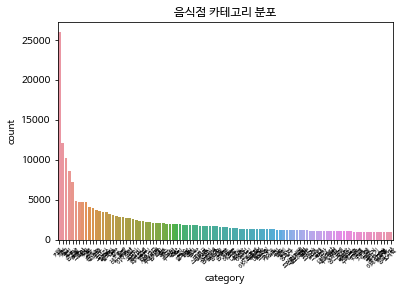

In [ ]:
set_config()
data = load_dataframes()
show_store_categories_graph(data)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


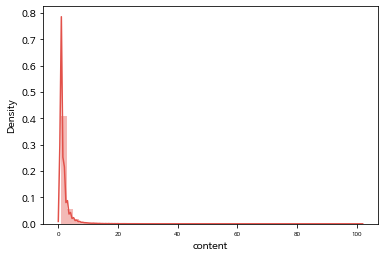

In [ ]:
show_store_review_distribution_graph(data)

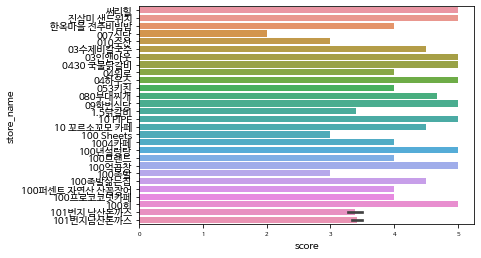

In [ ]:
show_store_average_ratings_graph(data)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


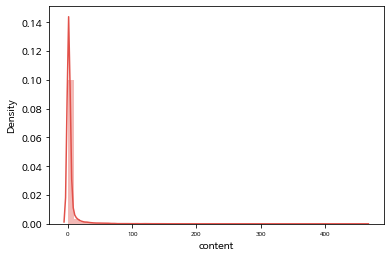

In [ ]:
show_user_review_distribution_graph(data)

In [ ]:
stores_reviews = pd.merge(
        data["stores"], data["reviews"], left_on="id", right_on="store"
    )


store_group = stores_reviews.groupby(['store','store_name']).count()

In [ ]:
stores_reviews = pd.merge(
        data["stores"], data["reviews"], left_on="id", right_on="store"
    )


store_group = stores_reviews.groupby(['store','store_name'])

x = store_group.count().reset_index()['store_name']
y = store_group.count().reset_index()['content']

In [ ]:
len(x.unique())

31747

In [ ]:
y

0        1
1        1
2        1
3        1
4        1
        ..
45695    4
45696    1
45697    1
45698    2
45699    1
Name: content, Length: 45700, dtype: int64

<AxesSubplot:xlabel='store_name', ylabel='content'>

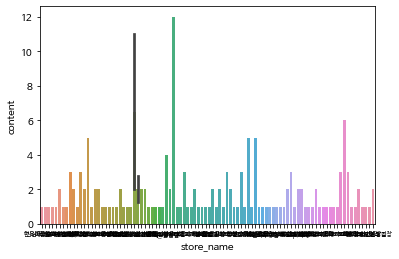

In [ ]:
import seaborn as sns
sns.barplot(x = store_group.reset_index().head(100)['store_name'], y = store_group.reset_index().head(100)['content'])

In [ ]:
stores_reviews = pd.merge(
    data["stores"], data["reviews"], left_on="id", right_on="store"
)
scores_group = stores_reviews.groupby(["store", "store_name"])

#수치형 컬럼의 store,store_name별로 평균을 구한다

scores = scores_group.mean()

In [ ]:
scores

,,id_x,id_y,user,score
store,store_name,,,,
15,써리힐,15.0,1.0,68632.0,5.00
18,진삼미 샌드위치,18.0,2.0,389728.0,5.00
19,한옥마을 전주비빔밥,19.0,3.0,68716.0,4.00
37,007식당,37.0,4.0,774353.0,2.00
38,010수산,38.0,5.0,115682.0,3.00
...,...,...,...,...,...
360493,지구촌 가정식,360493.0,2398.5,149781.0,3.75
360499,지구촌한우생고기,360499.0,2401.0,17371.0,5.00
360505,지군포차,360505.0,2402.0,198050.0,4.00
